<a href="https://colab.research.google.com/github/mnmahir/best-fyp/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import Libraries**

In [26]:
# Google Drive
from google.colab import drive
# General
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import itertools
import random as python_random
# Keras Library
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPool2D
from keras.models import Model
from keras import backend as Kbackend
from keras.preprocessing import image
# ScikitLearn
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
# Others
import time
import os

print("Keras version: ", keras.__version__)
print("TensorFlow version:", tf.__version__)

Keras version:  2.4.3
TensorFlow version: 2.3.0


# **Initialize Functions**

# Tools

In [2]:
############################
# Solving class imbalance
############################
def get_freq_data(generator):
  class_data_labels = generator.classes
  total_class = len(IMAGE_CLASSES)
  freq_out = []

  for i in range(total_class):
    total_label_i = 0
    for ele in class_data_labels:
      if ele == i:
        total_label_i += 1
    freq_out.append(total_label_i)
  
  print("Total number of class is:", total_class, generator.class_indices)
  print("Total image in generator is: ", freq_out)
  return freq_out
############################
# Display training and validation curve
############################
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['Training', 'Validation'])

############################
# Display confusion matrix
############################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, subplot = 121):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        cm = np.round(cm,2)
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.subplot(subplot)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))  # Count number of classes for x & y axis lable
    plt.xticks(tick_marks, classes, rotation=45) # x-axis label rotated 45 degree
    plt.yticks(tick_marks, classes) # y-axis label
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
############################
# Show generated image
############################
def show_image_generated(generator, index, img_size):
  x, y = generator.__getitem__(index)
  img_plt = math.ceil(math.sqrt(BATCH_SIZE))
  grid_plt = str(img_plt)+str(img_plt)+str(1)
  plt.figure(1, figsize = (img_size,img_size))
  for i in range(BATCH_SIZE):
    plt.subplot(img_plt,img_plt,i+1)
    plt.imshow(x[i])
    plt.title(IMAGE_CLASSES[np.where(y[i] == 1.)[0][0]], fontsize = 2+img_size, pad = 0)
    plt.axis('off')
  plt.show()

###########################
# Show augmented image
###########################
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plot_augmented_images(img_generator, num, index_i = 0, index_j = 0):
    images_arr = [img_generator[index_i][0][index_j] for i in range(num)]
    fig, axes = plt.subplots(1, num, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.axis('off')
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

############################
# Show all prediction images
############################
def show_all_prediction_image(class_dir, generator, true_labels, pred_labels):
  image_freq = get_freq_data(generator)
  correct_pred = []
  wrong_pred = []
  for i in range(len(IMAGE_CLASSES)):
    correct_num = 0
    wrong_num = 0
    for j in range(len(true_labels)):
      if true_labels[j] == i:
        if true_labels[j] == pred_labels[j]:
          correct_num += 1
        else:
          wrong_num += 1
    correct_pred.append(correct_num)
    wrong_pred.append(wrong_num)

  print('Correctly predicted:',correct_pred)
  print('Wrongly predicted:',wrong_pred)

  label_index_show = 0

  disp_col = 8

  for i, class_f in enumerate(os.listdir(class_dir)):
    img_dir = class_dir + '/' + class_f
    display_row = math.ceil(image_freq[i]/disp_col)
    batch_holder = np.zeros((image_freq[i], IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    print('========================================================================')
    print('True Class:', class_f)
    print('Total images:', image_freq[i],'| Correctly predicted:',correct_pred[i],'| Wrongly predicted:',wrong_pred[i])
    print('========================================================================')

    for j,img in enumerate(os.listdir(img_dir)):
      img = image.load_img(os.path.join(img_dir,img), target_size=(IMAGE_WIDTH,IMAGE_HEIGHT))
      batch_holder[j, :] = img

    plt.figure(1, figsize = (disp_col*1.8,display_row*2.1))

    for j,img in enumerate(batch_holder):
      title = 'T: ' + IMAGE_CLASSES[true_labels[label_index_show]] + '\nP: ' + IMAGE_CLASSES[pred_labels[label_index_show]]
      plt.subplot(display_row, disp_col, j+1)
      if true_labels[label_index_show] == pred_labels[label_index_show]:
        plt.title(title)
      else:
        plt.title(title,color = 'red')
      plt.axis('off')
      plt.imshow(img/256.)
      label_index_show += 1
      
    plt.show()

############################
# Get input image for pre-trained model
############################
def get_pretrained_model_input_size(MODEL = 'None'):
  if MODEL == 'Xception' or MODEL == 'InceptionV3' or MODEL == 'InceptionResNetV2':
    return (299, 299, 3)
  elif MODEL == 'VGG16' or MODEL == 'VGG19' or MODEL == 'ResNet50V2' or MODEL == 'ResNet101V2' or MODEL == 'ResNet152V2' or MODEL == 'MobileNetV2' or MODEL == 'DenseNet121' or MODEL == 'DenseNet169' or MODEL == 'DenseNet201' or MODEL == 'NASNetMobile':
    return (224, 224, 3)
  elif MODEL == 'NASNetLarge':
    return (331, 331, 3)
  else:
    print("Invalid model name/ not defined")
    return (0,0,0)

# Data Augmentation

In [3]:
############################
# Training data generator
############################
def get_train_generator():
  print("Getting train generator...")
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range = 90,
      vertical_flip = True,
      horizontal_flip = True,
      fill_mode = 'reflect'
  )

  generator = image_generator.flow_from_directory(
      batch_size = BATCH_SIZE,
      directory = train_path,
      shuffle = True,             # Shuffle input after each epoch
      target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),   # Set image size to be [x]px by [y]px set in IMAGE_SIZE
      class_mode = 'categorical',
      seed = SEED,
  )

  return generator
############################
# Validation data generator
############################
def get_valid_generator():
  print("Getting valid generator...")
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255
  )

  generator = image_generator.flow_from_directory(
      batch_size = BATCH_SIZE,
      directory = valid_path,
      shuffle = False,             # Shuffle input after each epoch
      target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),   # Set image size to be [x]px by [y]px set in IMAGE_SIZE
      class_mode = 'categorical',
      seed = SEED,
  )

  return generator
############################
# Test data generator
############################
def get_test_generator():
  print("Getting test generator...")
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255
  )

  generator = image_generator.flow_from_directory(
      batch_size = BATCH_SIZE,
      directory = test_path,
      shuffle = False,             # Shuffle input after each epoch
      target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),   # Set image size to be [x]px by [y]px set in IMAGE_SIZE
      class_mode = 'categorical',
      seed = SEED,
  )

  return generator

# Model Development

In [4]:
############################
# Custom model
############################
def get_custom_model(print_summary = False):
  model = Sequential()

  #model.add(Convolution2D(nb_filters, (5, 5), strides=(1, 1), padding='same', input_shape=input_shape))
  model.add(Convolution2D(nb_filters, (5, 5), activation = 'relu', padding='same', input_shape=input_shape))
  #model.add(MaxPooling2D(pool_size=pool_size))

  model.add(Convolution2D(nb_filters, (5, 5), activation = 'relu', padding='same'))
  model.add(MaxPool2D(pool_size=pool_size))
  model.add(Dropout(rate=0.25))
  #model.add(Convolution2D(nb_filters, (3, 3)))
  #model.add(Activation('relu'))

  #model.add(Activation('tanh'))
  model.add(Convolution2D(nb_filters*2, (3, 3), activation='relu', padding='same'))

  model.add(Convolution2D(nb_filters*2, (3, 3), activation='relu', padding='same'))

  model.add(Convolution2D(nb_filters*2, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=pool_size))
  model.add(Dropout(rate=0.25))

  model.add(Convolution2D(nb_filters*2, (3, 3), activation='relu', padding='same'))

  model.add(Convolution2D(nb_filters*2, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=pool_size))
  model.add(Dropout(rate=0.25))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(rate=0.5))

  #model.add(Dense(128, activation='relu'))
  #model.add(Dropout(0.5))
  #model.add(Dropout(0.15))

  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  if print_summary:
    model.summary()

  return model

In [5]:
############################
# Transfer learning model
############################
def get_pretrained_model(transfer_learning_model = 'None', weights = None, unfreeze_last_layer = 0, print_summary = False):
  ################ Choose Pre-trained model #########################
  if transfer_learning_model == 'Xception':
    selected_model = "Xception pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.Xception(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)
  
  elif transfer_learning_model == 'VGG16':
    selected_model = "VGG16 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.VGG16(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)
  
  elif transfer_learning_model == 'VGG19':
    selected_model = "VGG19 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.VGG19(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'ResNet50V2':
    selected_model = "ResNet50V2 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.ResNet50V2(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)
  
  elif transfer_learning_model == 'ResNet101V2':
    selected_model = "ResNet101V2 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.ResNet101V2(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'ResNet152V2':
    selected_model = "ResNet152V2 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.ResNet152V2(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'InceptionV3':
    selected_model = "InceptionV3 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.InceptionV3(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'InceptionResNetV2':
    selected_model = "InceptionResNetV2 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.InceptionResNetV2(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'MobileNetV2':
    selected_model = "MobileNetV2 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'DenseNet121':
    selected_model = "DenseNet121 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.DenseNet121(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'DenseNet169':
    selected_model = "DenseNet169 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.DenseNet169(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'DenseNet201':
    selected_model = "DenseNet201 pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.DenseNet201(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'NASNetMobile':
    selected_model = "NASNetMobile pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.NASNetMobile(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)

  elif transfer_learning_model == 'NASNetLarge':
    selected_model = "NASNetLarge pre-trained model selected"
    print(selected_model)
    pretrained_model = tf.keras.applications.NASNetLarge(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL), weights = weights, include_top=False)
  
  else:
    print("Not defined / Does not exist")
    return 0
  ##################################################################
  # Freeze early layers
  for layer in pretrained_model.layers:
    if unfreeze_last_layer < len(pretrained_model.layers):
      layer.trainable = False
      unfreeze_last_layer += 1

  # Print summary of pre-trained model
  if print_summary:
    pretrained_model.summary()
    if unfreeze_last_layer > 0:
      print("####################### UNFREEZED LAYER #########################")
      print("Layer            Trainable")
      for layer in pretrained_model.layers:
        if layer.trainable == True:
          sp = '      '[len(layer.name)-9:]
          print(layer.name, sp, layer.trainable)

  model = Sequential()
  model.add(pretrained_model)

  # Fine tuning our layers - you can add more if you want
  model.add(Flatten())
  model.add(Dropout(0.8))
  model.add(Dense(1024, activation = 'relu'))

  # Prediction layer
  model.add(layers.Dense(len(IMAGE_CLASSES), activation = 'softmax'))

  # Compile model
  model.compile(
      optimizer='adam',
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  if print_summary:
    print("###################### AFTER FINE TUNING ########################")
    model.summary()
    print(selected_model)

  return model


# **Training**

In [6]:
# Path where dataset is located
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/FYP Stuff/Datasets/'
dataset_name = 'Dataset 400A'
train_path = dataset_path + dataset_name + '/Train'
valid_path = dataset_path + dataset_name + '/Valid'    # Some literature use the term "test set" / "valid set" but it is actually a "dev set". This is the set that is iterated during training.
test_path = dataset_path + dataset_name + '/Valid'  # Test set helps evaluate how good your final system is. It's ok not to have test set.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
IMAGE_CLASSES = ['Normal','Grade I','Grade II','Grade III']         # Naming Classes (The names must be in the same order as in dataset folder (usually alphabetically))
MODEL = 'Xception'              # Xception, VGG16, VGG19, InceptionResNetV2, NASNetLarge, EfficientNetB7, DenseNet201, ResNet152V2
SAVE_MODEL_NAME = MODEL + '_' + dataset_name + '_awesome_model.h5'         # Name of the model to save after training
BATCH_SIZE = 64                 # Mini-batch size
SEED = 2020                     # Fixed randomness (For reproducible result!)
python_random.seed(SEED)        # necessary for starting core Python generated random numbers in a well-defined state.
np.random.seed(SEED)            # necessary for starting Numpy generated random numbers in a well-defined state.
tf.random.set_seed(SEED)        # will make random number generation in the TensorFlow backend have a well-defined initial state.

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL = get_pretrained_model_input_size(MODEL)
print("Training on", MODEL)
print("Input:",IMAGE_WIDTH,'x',IMAGE_HEIGHT,'x',IMAGE_CHANNEL)

Training on Xception
Input: 299 x 299 x 3


In [8]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()

Getting train generator...
Found 843 images belonging to 4 classes.
Getting valid generator...
Found 212 images belonging to 4 classes.
Getting test generator...
Found 212 images belonging to 4 classes.


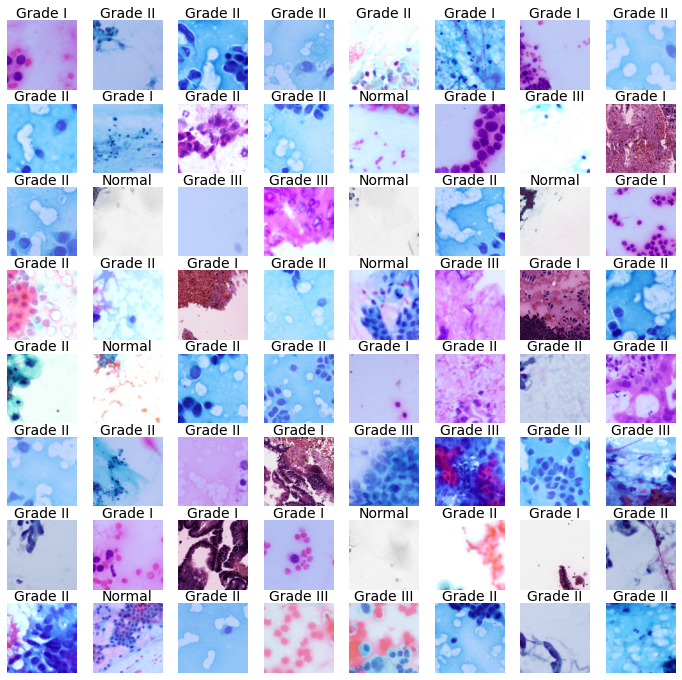

In [9]:
# Show image generated by generator
# show_image_generated(train_generator, index = 3, img_size = 12)  # Print image generated by generator. Change index to see different batch (start at 0)
# plot_augmented_images(train_generator,5,0,0)

In [11]:
# Check number of image in each class
train_freq = get_freq_data(train_generator)
valid_freq = get_freq_data(valid_generator)
valid_data_freq = np.array(valid_freq)/np.array(train_freq)
print("Valid data Percentage:",valid_data_freq)



Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [144, 174, 339, 186]
Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [36, 44, 85, 47]
Valid data Percentage: [0.25       0.25287356 0.25073746 0.25268817]


In [12]:
model = get_pretrained_model(MODEL, weights = 'imagenet', unfreeze_last_layer = 0, print_summary = True,)

Xception pre-trained model selected
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________

Epoch 1/100
14/13 [===============================] - 20s 1s/step - loss: 11.7401 - accuracy: 0.4982 - val_loss: 1.6149 - val_accuracy: 0.6887
Epoch 2/100
14/13 [===============================] - 20s 1s/step - loss: 0.8603 - accuracy: 0.7319 - val_loss: 0.7672 - val_accuracy: 0.7594
Epoch 3/100
14/13 [===============================] - 20s 1s/step - loss: 0.5808 - accuracy: 0.7805 - val_loss: 0.6207 - val_accuracy: 0.8066
Epoch 4/100
14/13 [===============================] - 20s 1s/step - loss: 0.4684 - accuracy: 0.8102 - val_loss: 0.4916 - val_accuracy: 0.7877
Epoch 5/100
14/13 [===============================] - 20s 1s/step - loss: 0.4435 - accuracy: 0.8327 - val_loss: 0.5215 - val_accuracy: 0.7972
Epoch 6/100
14/13 [===============================] - 19s 1s/step - loss: 0.4185 - accuracy: 0.8410 - val_loss: 0.4715 - val_accuracy: 0.8113
Epoch 7/100
14/13 [===============================] - 19s 1s/step - loss: 0.4503 - accuracy: 0.8422 - val_loss: 0.4993 - val_accuracy: 0.8302
Epoch

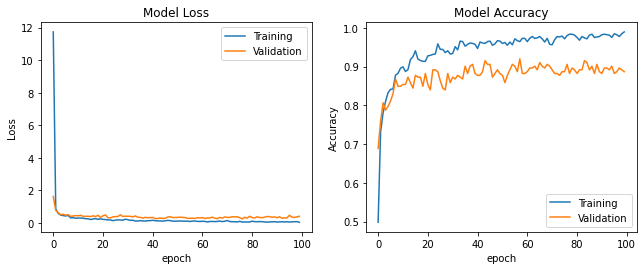

In [13]:
EPOCH = 100                      # Number of training epoch

time_start = time.time()
history = model.fit(
    x = train_generator,
    validation_data = valid_generator,
    epochs = EPOCH,
    verbose = 1,
    steps_per_epoch = train_generator.samples / train_generator.batch_size ,
    validation_steps = valid_generator.samples / valid_generator.batch_size
)
time_end = time.time()
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate_generator(train_generator, steps=24)
Validation_Accuracy = model.evaluate_generator(test_generator, steps=24)

 4/24 [====>.........................] - 1s 241ms/step - loss: 0.4023 - accuracy: 0.8868
Trained on Xception
Time taken: 2182.7980892658234 s
The Model Accuracy for Train data is:  99.29%
The Model Accuracy for Validation data is:  88.68%
FINAL VALIDATION ACCURACY MEAN-5:  0.8886792540550232


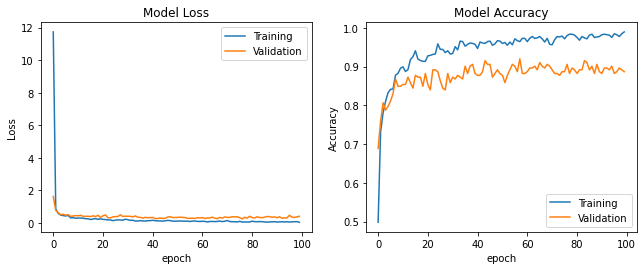

In [20]:
final_accuracy = history.history["val_accuracy"][-5:]
Training_Accuracy = model.evaluate(train_generator, steps=24)
Validation_Accuracy = model.evaluate(test_generator, steps=24)
print("Trained on", MODEL)
print("Time taken:", (time_end - time_start), "s")
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))
print("FINAL VALIDATION ACCURACY MEAN-5: ", np.mean(final_accuracy))
# Loss and Accuracy
plt.subplots(figsize=(9,3.5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

# **Save & Reload Model**

In [140]:
model.save(SAVE_MODEL_NAME) #Save
reloaded_model = tf.keras.models.load_model(SAVE_MODEL_NAME) #Load

# **Evaluation**

**Confusion Matrix**

In [141]:
# True label
true_labels = test_generator.classes  # Get label of valid_generator
# Prediction label
predictions = reloaded_model.predict(x=test_generator, steps=len(test_generator),verbose = 0)
pred_labels = np.argmax(predictions, axis=-1)

Confusion matrix, without normalization
[[32  1  2  1]
 [ 0 40  0  4]
 [ 0  1 81  3]
 [ 1  1 10 35]]
Normalized confusion matrix
[[0.89 0.03 0.06 0.03]
 [0.   0.91 0.   0.09]
 [0.   0.01 0.95 0.04]
 [0.02 0.02 0.21 0.74]]


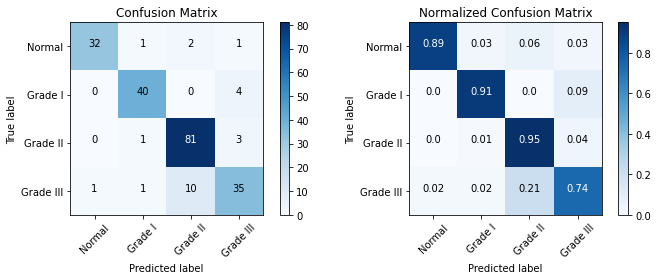

In [142]:
# Plot Confusion Matrix
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels)
plt.subplots(figsize=(10,4))
plot_confusion_matrix(cm=cm, classes=IMAGE_CLASSES, title='Confusion Matrix',normalize=False, subplot=121)
plot_confusion_matrix(cm=cm, classes=IMAGE_CLASSES, title='Normalized Confusion Matrix',normalize=True, subplot=122)

**Other Metrics**

In [17]:
report = metrics.classification_report(y_true = true_labels, y_pred = pred_labels, target_names=IMAGE_CLASSES)
print(report)

              precision    recall  f1-score   support

      Normal       0.97      0.89      0.93        36
     Grade I       0.93      0.91      0.92        44
    Grade II       0.87      0.95      0.91        85
   Grade III       0.81      0.74      0.78        47

    accuracy                           0.89       212
   macro avg       0.90      0.87      0.88       212
weighted avg       0.89      0.89      0.89       212



Total number of class is: 4 {'0Normal': 0, '1Grade I': 1, '2Grade II': 2, '3Grade III': 3}
Total image in generator is:  [36, 44, 85, 47]
Correctly predicted: [32, 40, 81, 35]
Wrongly predicted: [4, 4, 4, 12]
True Class: 0Normal
Total images: 36 | Correctly predicted: 32 | Wrongly predicted: 4


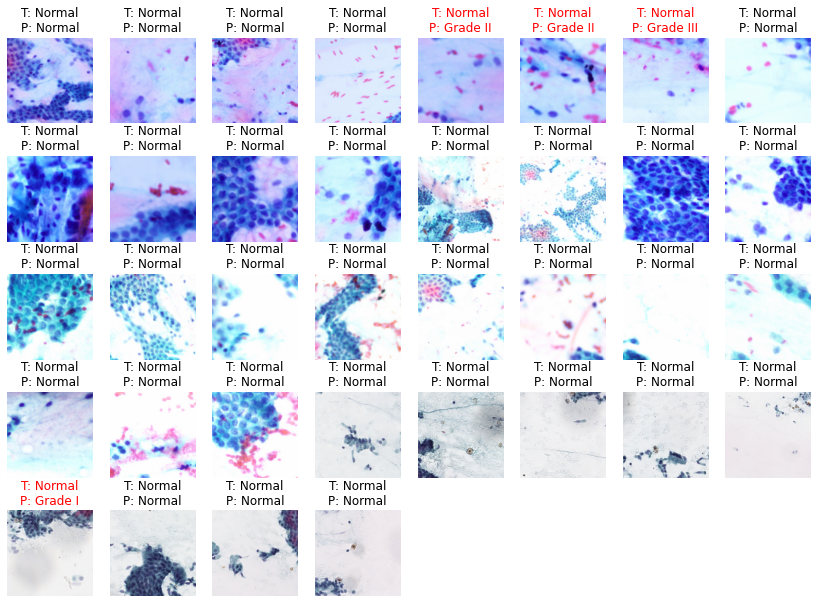

True Class: 1Grade I
Total images: 44 | Correctly predicted: 40 | Wrongly predicted: 4


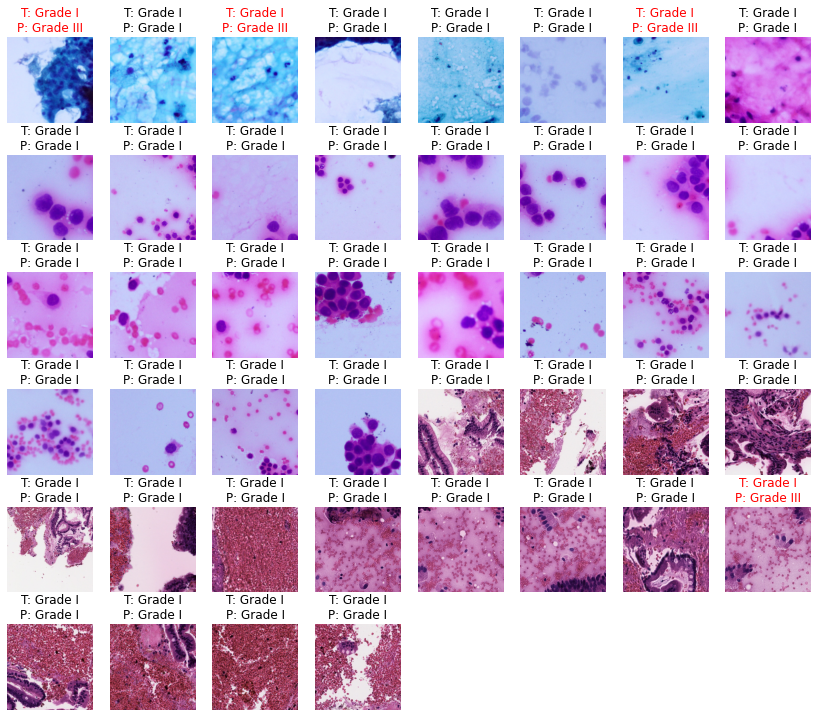

True Class: 2Grade II
Total images: 85 | Correctly predicted: 81 | Wrongly predicted: 4


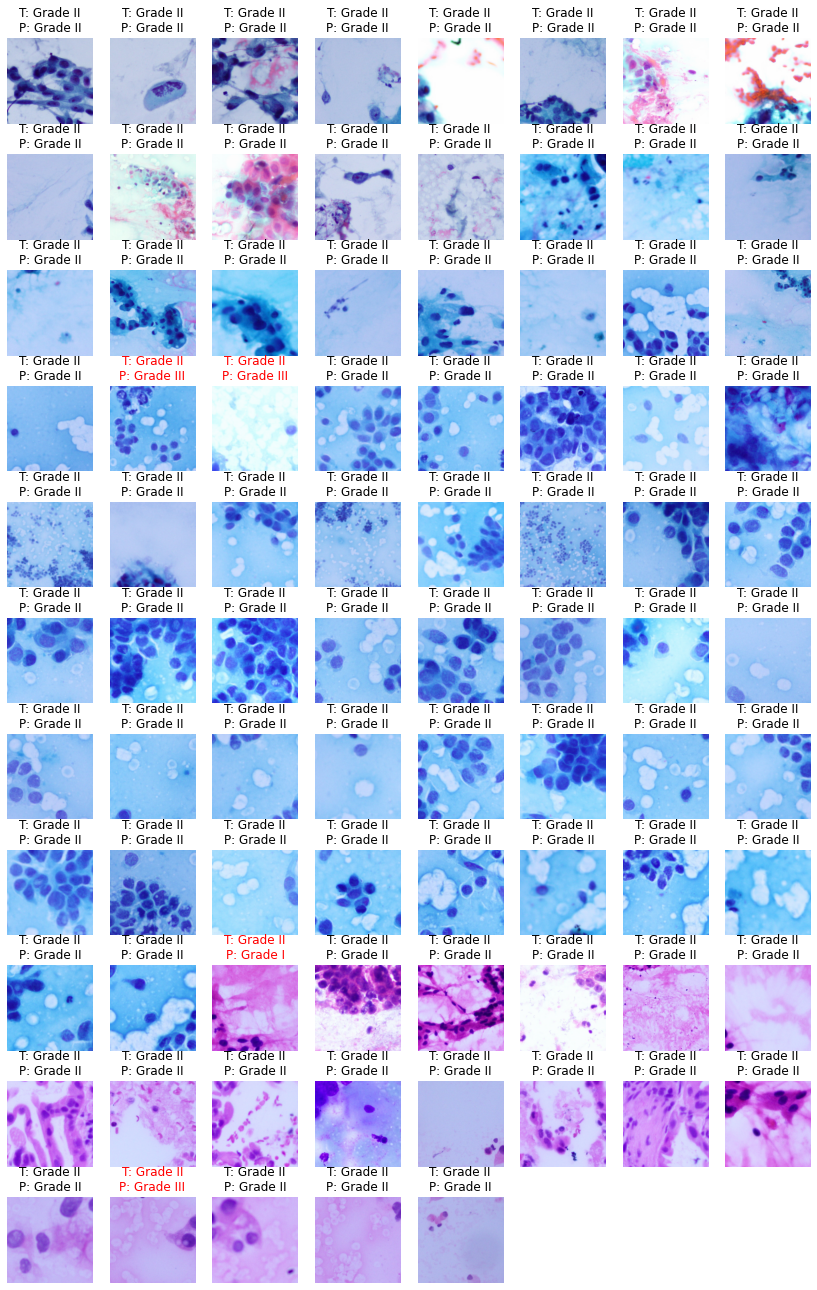

True Class: 3Grade III
Total images: 47 | Correctly predicted: 35 | Wrongly predicted: 12


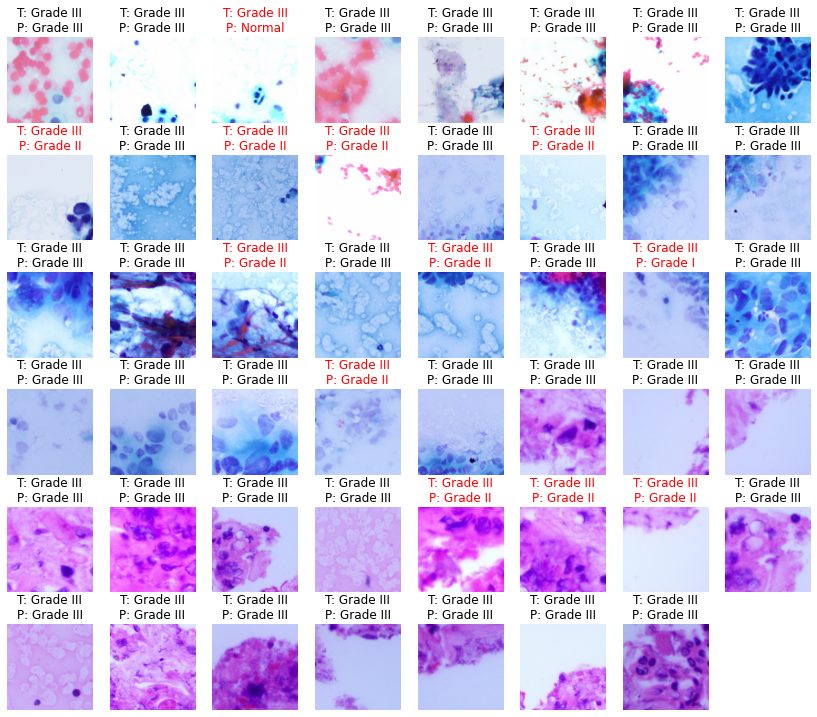

In [148]:
show_all_prediction_image(valid_path, valid_generator, true_labels, pred_labels)